In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import rasterize
import torch
import time

In [2]:
#TODO: parallelisieren / gdal python binding über cli direct call / 24xhöhe von bbox, nur steps nach rechts und dann splitten? / polygonbasiert 


# Bounding box und Geometrie für Sentinel-Abfrage

In [3]:
df_raw = pd.read_csv('bern_landkult.csv')
labels = pd.read_csv('../Level_hierarchy.csv', usecols=['level3', 'LNF_code'])
labels.columns=['level3', 'LNF_CODE']

In [4]:
df_landkult = pd.merge(df_raw, labels, how='left', on='LNF_CODE' )
df_landkult = df_landkult.dropna(subset = ['level3'])

In [5]:
df_landkult['geometry'] = df_landkult['geometry'].apply(wkt.loads)
crs = {'init': 'epsg:2056'}
gdf = gpd.GeoDataFrame(df_landkult, crs=crs, geometry='geometry')
gdf_32632 = gdf.to_crs(32632)
gdf_32632.head()

c:\Users\Tom\.virtualenvs\AgroLuege-VcgfzIc1\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Unnamed: 0,IST_DEF,KULTGRUPPE,KULTGRUT_K,KULTGRUT_1,LNF_CODE,KULTURT_KU,KULTURT__1,NHG,NUTZUNG,...,DARSGRUT_D,DARSGRUT_1,GEOID,HAUPTKAT,HAKAT_HK_D,HAKAT_HK_F,Shape_Leng,Shape_Area,geometry,level3
0,0,0,2041,übrige Nutzfläche Wiese,autres prairies,613,Übrige Dauerwiesen (ohne Weiden),Autres prairies permanentes (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,766613,1,Dauerwiesen,Prairies permanentes,1114.998396,30892.048265,"POLYGON ((399301.942 5185353.379, 399306.541 5...",21.0
1,1,0,2041,übrige Nutzfläche Wiese,autres prairies,613,Übrige Dauerwiesen (ohne Weiden),Autres prairies permanentes (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,309561,1,Dauerwiesen,Prairies permanentes,194.265546,2273.000733,"POLYGON ((395533.888 5202486.154, 395519.846 5...",21.0
2,2,0,2039,übrige Nutzfläche,autres SAU,857,"Hecken-, Feld- und Ufergehölze (mit Pufferstre...","Haies, bosquets champêtres et berges boisées (...",0,1,...,keine BFF I,aucune SPB I,301706,8,"Hecken-, Feld- und Ufergehölze","Haies, bosquets et berges boisées",204.997401,883.631964,"POLYGON ((377044.226 5236483.316, 377041.905 5...",14.0
3,3,0,2048,Grünland,prairie,601,Kunstwiesen (ohne Weiden),Prairies artificielles (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,969184,0,Ackerfläche,Terres cultivées,387.805081,6898.488772,"POLYGON ((390521.806 5184008.833, 390520.286 5...",21.0
4,4,0,2048,Grünland,prairie,601,Kunstwiesen (ohne Weiden),Prairies artificielles (sans les pâturages),0,1,...,keine BFF I,aucune SPB I,950199,0,Ackerfläche,Terres cultivées,213.983203,1756.279697,"POLYGON ((408013.194 5220252.410, 408013.565 5...",21.0


In [6]:
#gdf_32632.plot()

In [7]:
# from sentinelhub import (
#     CRS,
#     BBox,
#     bbox_to_dimensions
# )

Sentinel stellt Funktionen bereit, die mithilfe des Parameters "resolution" die Pixelgrösse angibt. Damit können wir einen durch 240 pixel (=2.4km) teilbaren Ausschnitt wählen, den wir jeweils mit einem request bei Sentinel abfragen können.
Wir werden ein Mosaik aus 23 x 41 Elementen haben für den Kanton Bern.

In [ ]:
x_start = 361630.
y_start = 5140066.
x_end = x_start + 23*2400
y_end = y_start + 41*2400
bbox_to_dimensions(BBox(bbox=(x_start, y_start, x_end, y_end), crs=32632), resolution=10)

In [ ]:
area_box = []
x_start = 361630.
y_start = 5140066.
step= 240
x_end = x_start + 230*step
y_end = y_start + 410*step
x_coordinate = list(np.arange(x_start, x_end, step))
y_coordinate = list(np.arange(y_start, y_end, step))
for i in range(len(x_coordinate)):
    for j in range(len(y_coordinate)):
        area = gdf_32632.cx[x_coordinate[i]:x_coordinate[i]+240, y_coordinate[j]:y_coordinate[j]+240].Shape_Area.sum()/10000
        box_entry = {'x1': x_coordinate[i], 'y1': y_coordinate[j],'x2': x_coordinate[i]+240,'y2': y_coordinate[j]+240, 'area': area}
        area_box.append(box_entry)
area_boxes = pd.DataFrame(area_box)

In [ ]:
plt.scatter(x='x1', y='y1', s='area', data=area_boxes, alpha=0.5, c='g')

In [ ]:
area_boxes.replace(0, np.nan, inplace=True)
print(area_boxes.area.isna().sum())

In [ ]:
bboxes = area_boxes.copy()
bboxes = bboxes.dropna(subset = ['area'])
bboxes.to_csv('../raw_data/BernCrop/bboxes_sentinel_240x240.csv')
bboxes = bboxes.drop(columns=['x2', 'y2', 'area'])

### Bounding-Box für ETH

In [ ]:
x_start,x_end, y_start, y_end

In [ ]:
gdf_32632.cx[x_start:x_end, y_start: y_end].plot()

# Rasterize GIS-Data
## Label-Ebene
Die Polygonzüge der einzelnen Landwirtschaftsfelder haben jeweils ein LNF_Code hinterlegt. In einem ersten Schritt wird jedem Polygonzug das Label der 3. Hierarchie (3level) hinterlegt. Die Originaldaten des Kanton Bern werden in das erforderliche Koordinatensystem WGS 84 / UTM zone 32N umgewandelt.
In einem zweiten Schritt werden die Polygon-Label auf Rasterebene umgewandelt, so dass jedes Pixel (10 x 10m) ein Label hat. Das Ergebnis ist eine Liste von numpy-arrays, bei dem jeder array die 2.4 x 2.4km der Sentinel-Abfrage darstellt.

In [8]:
gdf_pair = gdf_32632[['geometry', 'level3']]

In [9]:
test_gdf = gdf_pair.itertuples(index=False, name=None)
test_gdf = list(test_gdf)


In [10]:
bboxes = pd.read_csv(r'..\raw_data\BernCrop\bboxes_sentinel_24x24.csv',index_col=[0])

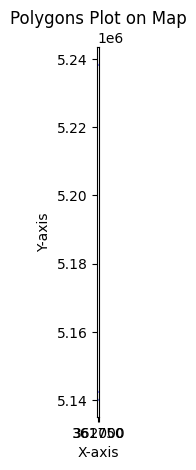

In [11]:
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming your data is in a CSV file named 'polygons_data.csv'
data = bboxes[bboxes.index.isin([10,409,410])]

# Create a GeoDataFrame
geometry = [Polygon([(row['x1'], row['y1']), (row['x2'], row['y1']),
                     (row['x2'], row['y2']), (row['x1'], row['y2'])]) for _, row in data.iterrows()]

gdf = gpd.GeoDataFrame(data, geometry=geometry)

# Plot the GeoDataFrame
gdf.plot(edgecolor='blue', facecolor='green', alpha=0.4)
plt.title('Polygons Plot on Map')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [12]:
import time
import rasterio
from rasterio.features import rasterize

def raster(coord, geo_df, field_df):
    """
    coord: DataFrame with x and y coordinates of bounding_boxes
    geo_df: list of tuple with geometry (Polygon) and value pair
    """
    # result_list_pixel = []
    # result_list_field = []
    
    with rasterio.Env():
        # for i, row in coord.iterrows():
        x_coord, y_coord = coord['x1'].min(), coord['y1'].min()
        start_time = time.time()
        # result = rasterize(geo_df, out_shape=(24, 24*410), transform=(10, 0, x_coord, 0, -10, y_coord, 0, 0, 1))
        result_pixel = rasterize(geo_df, out_shape=(24, 24*410), transform=(10, 0, x_coord, 0, -10, y_coord, 0, 0, 1))
        result_field = rasterize(field_df, out_shape=(24, 24*410), transform=(10, 0, x_coord, 0, -10, y_coord, 0, 0, 1))
        print(f"End Time: {time.time() - start_time}")
    
    return result_pixel,result_field



## Feld-Ebene

In [13]:
gdf_pair_field = gdf_32632[['geometry', 'Unnamed: 0', 'level3']]

In [14]:
gdf_pair_field.columns=['geometry', 'gt_instance', 'level3']


In [15]:
gdf_pair_field['gt_instance'] = gdf_pair_field['gt_instance']+1000000
gdf_pair_field.head()

c:\Users\Tom\.virtualenvs\AgroLuege-VcgfzIc1\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,gt_instance,level3
0,"POLYGON ((399301.942 5185353.379, 399306.541 5...",1000000,21.0
1,"POLYGON ((395533.888 5202486.154, 395519.846 5...",1000001,21.0
2,"POLYGON ((377044.226 5236483.316, 377041.905 5...",1000002,14.0
3,"POLYGON ((390521.806 5184008.833, 390520.286 5...",1000003,21.0
4,"POLYGON ((408013.194 5220252.410, 408013.565 5...",1000004,21.0


Falls wir die Zuordnung Feld - Label nochmals brauchen, exportieren wir dieses als csv. Dies gäbe uns die Möglichkeit, ein stratified Fold zu machen.

In [16]:
gdf_pair_field.drop('geometry',axis=1).to_csv(r'gt_instance-level3.csv') 

In [17]:
gdf_pair_field = gdf_pair_field.drop('level3', axis=1)

In [18]:
pair_gdf = gdf_pair_field.itertuples(index=False, name=None)
pair_gdf = list(pair_gdf)

In [19]:
# loop over slices
result_pixel_list = []
result_field_list = []

for slice in range(0, 230):
    start_index = slice * 410
    end_index = (slice + 1) * 410
    indexes = [i for i in range(start_index, end_index)]
    # print(indexes)
    bboxes_slice = bboxes[bboxes.index.isin(indexes)]
    result_pixel,result_field = raster(bboxes_slice, test_gdf,pair_gdf)
    result_pixel_list.append(result_pixel.reshape(-1,24,24))
    result_field_list.append(result_field.reshape(-1,24,24))
    


End Time: 46.027955293655396
End Time: 46.218514919281006
End Time: 44.32979941368103
End Time: 44.73863506317139
End Time: 47.534414768218994
End Time: 46.0167818069458
End Time: 46.24760603904724
End Time: 46.16606688499451
End Time: 46.21455764770508
End Time: 45.09385704994202
End Time: 48.43558478355408
End Time: 54.433048486709595
End Time: 56.87207055091858
End Time: 47.09991383552551
End Time: 47.89213037490845
End Time: 47.088465213775635
End Time: 46.786316871643066
End Time: 47.145737648010254
End Time: 45.561893701553345
End Time: 45.60400056838989
End Time: 46.085999727249146
End Time: 45.80300045013428
End Time: 45.74299955368042
End Time: 46.196035861968994
End Time: 45.70605444908142
End Time: 46.25900650024414
End Time: 45.97800254821777
End Time: 45.797014236450195
End Time: 46.01801586151123
End Time: 45.47800254821777
End Time: 46.37324571609497
End Time: 45.916921615600586
End Time: 45.509615421295166
End Time: 46.07012152671814
End Time: 45.63499999046326
End Time

In [20]:
np.array(result_pixel_list).shape

(230, 410, 24, 24)

In [21]:
np.array(result_field_list).shape

(230, 410, 24, 24)

In [ ]:
np.unique(result_pixel_list[0])

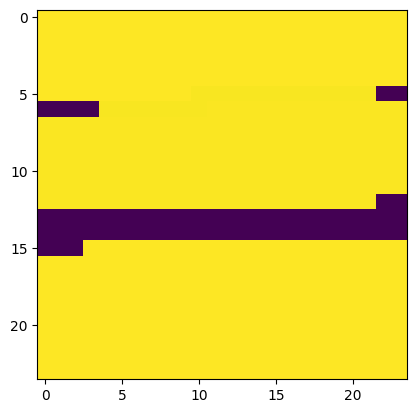

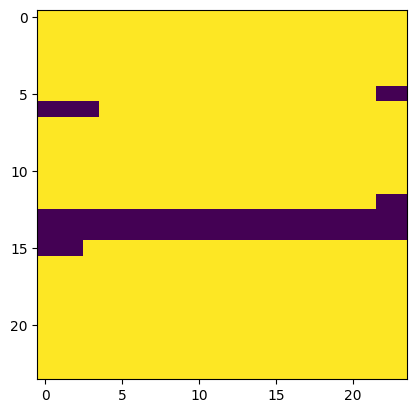

In [22]:
plt.imshow(result_field_list[1][3])
plt.show()
plt.imshow(result_pixel_list[1][3])
plt.show()

In [23]:
result_pixel_list = np.array(result_pixel_list).reshape(-1,24,24)
result_field_list = np.array(result_field_list).reshape(-1,24,24)

In [24]:
result_field_list = result_field_list.astype(int)

In [25]:
result_field_list

array([[[      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ..., 1161663, 1161663, 1161663],
        [1161663, 1161663, 1161663, ..., 1153685, 1153685, 1153685],
        ...,
        [      0,       0,       0, ..., 1232548, 1232548, 1232548],
        [1115244, 1115244, 1115244, ...,       0,       0,       0],
        [      0,       0,       0, ..., 1071967, 1071967, 1198394]],

       [[1198394, 1198394, 1198394, ..., 1146356, 1146356, 1146356],
        [1148859, 1148859, 1148859, ..., 1013597, 1013597, 1013597],
        [      0,       0,       0, ..., 1142520, 1142520, 1142520],
        ...,
        [1260878, 1052751, 1052751, ..., 1260030, 1260030, 1260030],
        [1260030, 1260030, 1260030, ..., 1267976, 1267976,       0],
        [      0,       0,       0, ...,       0,       0,       0]],

       [[      0, 1238563, 1238563, ..., 1162135, 1162135, 1162135],
        [1162135, 1162135, 1162135, ..., 1266035, 1266035, 1266035],
    

In [26]:
tensor_pixel= torch.Tensor(result_pixel_list)
print(tensor_pixel.size())
tensor_field= torch.Tensor(result_field_list)
print(tensor_field.size())

torch.Size([94300, 24, 24])
torch.Size([94300, 24, 24])


In [27]:
torch.save(tensor_pixel, '../raw_data/BernCrop/tensor_label_24x24.pt')
torch.save(tensor_field, '../raw_data/BernCrop/tensor_field_24x24.pt')